# Exponential example.

In this notebook, we demonstrate the calculation of error bounds for the Swiss Army infinitesimal jackknife for a simple scalar exponential family model.  Although the model is trivial, it simplicity aids understanding the interplay of different elements of Theorem 1.

In this notebook, we pay particular attention to the influence of the choice of $\Omega_\theta$ on the resulting bounds.

In [1]:
import autograd
import autograd.numpy as np
import scipy as sp
import paragami
import vittles

import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A convenience function to visually compare two variables.
def comparison_plot(x, y):
    plt.plot(x, x, 'k')
    plt.plot(x, y, 'r.')

First, draw some data from an exponential distribution.

9.935368315178039

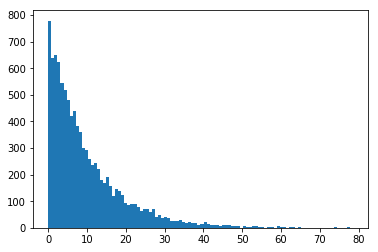

In [3]:
def generate_data(num_obs, theta_true):
    return np.random.exponential(np.exp(-1 * theta_true), num_obs)

num_obs = 10000
theta_true = np.log(0.1)

x = generate_data(num_obs, theta_true)

plt.hist(x, 100);
np.mean(x)

First, we specify the weighted MLE loss function.  In this case, the optimum is available in closed form.  For convenience we implement the closed form optimum and test that it matches the optimum of the loss function.

In [4]:
def get_opt(w, x):
    return np.log(np.sum(w)) - np.log(np.sum(w * x))

def eval_log_loss(theta, w, x):
    ll = -1 * np.sum(w * (-1 * x * np.exp(theta) + theta)) / num_obs
    return ll

w = np.ones(num_obs) + 0.1 * (np.random.random(num_obs) - 0.5)

# Test the loss function and optimum with random weights.
log_loss_objective = paragami.OptimizationObjective(
    lambda theta: eval_log_loss(theta, w, x))
log_loss_objective.reset()
log_loss_objective.set_log_every(1)
opt = sp.optimize.minimize(
    fun=log_loss_objective.f,
    jac=log_loss_objective.grad,
    method='bfgs',
    x0=theta_true,
    options={'gtol': 1e-12})
print(opt.message)

assert(np.abs(opt.x[0] - get_opt(w, x)) < 1e-8)


Iter 0: f = 3.29636573
Iter 1: f = 3.29634381
Iter 2: f = 3.29634381
Iter 3: f = 3.29634381
Optimization terminated successfully.


Get the optimum at the original weights.

In [5]:
w1 = np.ones(num_obs)
theta_opt = get_opt(w1, x)

Define an IJ predictor object using ``vittles``.

In [6]:
ij_predictor = \
    vittles.HyperparameterSensitivityLinearApproximation(
        lambda theta, w: eval_log_loss(theta, w, x),
        opt_par_value=np.array([theta_opt]),
        hyper_par_value=w1)

Get the IJ predictions and exact CV for a range of weights.

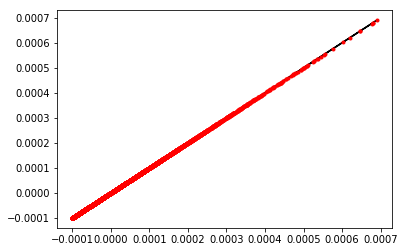

In [7]:
w_loo = np.ones(num_obs)

theta_ij = np.full(num_obs, float('nan'))
theta_cv = np.full(num_obs, float('nan'))
for n in range(num_obs):
    w_loo[n] = 0
    theta_ij[n] = ij_predictor.predict_opt_par_from_hyper_par(w_loo)
    theta_cv[n] = get_opt(w_loo, x)
    w_loo[n] = 1

comparison_plot(theta_cv - theta_opt, theta_ij - theta_opt)

# Error bound calculation.

We now calculate error bounds for the IJ approximation.

For this model, we will parameterize the log likelihood of datapoint $x_n$ as follows:

$$
\begin{align}
\ell\left(x_{n},\theta\right)	=& -\exp(\theta) x_{n} + \theta \\
\end{align}
$$

By allowing $\theta$ to take values in all of $\mathbb{R}$, we simplify some calculation and avoid large derivatives at the boundary of the valid domain.

For convenience, we define

$$
\begin{align}
M\left(w\right)	=& \frac{1}{N}\sum_{n=1}^{N}w_{n}x_{n}\\
S\left(w\right)	=& \frac{1}{N}\sum_{n=1}^{N}w_{n}x_{n}^{2}\\
\bar{w}	=& \frac{1}{N}\sum_{n=1}^{N}w_{n}.\\
\end{align}
$$

Given these definitions,

$$
\begin{align}
g_{n}\left(\theta\right)&=-\exp\left(\theta\right)x_{n}+1\\
h_{n}\left(\theta\right)&=-\exp\left(\theta\right)x_{n}
\end{align}
$$

and the aggregated quantities are

$$
\begin{align}
L\left(\theta,w\right) &= -M\left(w\right)\exp\left(\theta\right)+\bar{w}\theta\\
G\left(\theta,w\right) &= -M\left(w\right)\exp\left(\theta\right)+\bar{w}\\
H\left(\theta,w\right) &= -M\left(w\right)\exp\left(\theta\right).\\
\end{align}
$$

Note that

$$
\exp\left(\hat{\theta}\right)=\frac{1}{M(w_1)}.
$$

Define $w_1 = (1, ...., 1)^T$ to be the vector of unity weights.

We'll define the domain as $\Omega_{\theta}=\left(\theta_{min}, \theta_{max}\right)$.

### Assumption 1.

In this case, the objective is continuous and infinitely differentiable.

### Assumption 2.

By direct calculation,

$$
\begin{align}
|H\left(\theta, w_1\right)|^{-1}	&= \frac{1}{\exp\left(\theta\right) M(w_1)} 
    \le \frac{1}{\exp\left(\theta_{min}\right) M(w_1)}\Rightarrow \\
C_{op}&:= \frac{1}{\exp\left(\theta_{min}\right) M(w_1)}
\end{align}
$$

### Assumption 3.

We will bound Condition 1 directly without using Corollary 1, so the constants $C_g$ and $C_h$ are not needed.

### Assumption 4.

To calculate $L_h$, we need to choose a window $\Delta_\theta$ and upper bound the following quantity:

$$
\begin{align}
\sup_{\theta\in\left(\hat{\theta}-\Delta_{\theta},\hat{\theta}+\Delta_{\theta}\right)}
    \frac{\frac{1}{N} \left\Vert h\left(\theta\right)-h\left(\hat{\theta}\right) \right\Vert_{2}^{2}}
    {\left\Vert \theta-\hat{\theta} \right\Vert_{2}^{2}}.
\end{align}
$$


By convexity of $\left(\exp\left(\theta\right)-\exp\left(\hat{\theta}\right)\right)^{2}$, we have

$$
\begin{align}
\sup_{\theta\in\left(\hat{\theta}-\Delta_{\theta},\hat{\theta}+\Delta_{\theta}\right)}
    \frac{\frac{1}{N}\left\Vert h\left(\theta\right) - h\left(\hat{\theta}\right) \right\Vert_{2}^{2}}
         {\left\Vert \theta-\hat{\theta} \right\Vert_{2}^{2}}     
 =& \sup_{\theta\in\left(\hat{\theta}-\Delta_{\theta},\hat{\theta}+\Delta_{\theta}\right)}
    \frac{\frac{1}{N} \sum_{n=1}^N \left( h_n(\theta) - h_n(\hat\theta)\right)^2}
         {\left\Vert \theta-\hat{\theta} \right\Vert_{2}^{2}}	\\
 =& \sup_{\theta\in\left(\hat{\theta}-\Delta_{\theta},\hat{\theta}+\Delta_{\theta}\right)}
    \frac{\frac{1}{N} \sum_{n=1}^N x_n^2 \left( \exp(\theta) - \exp(\hat\theta)\right)^2}
         {\left\Vert \theta-\hat{\theta} \right\Vert_{2}^{2}}	\\
 =& S(w_1)   \sup_{\theta\in\left(\hat{\theta}-\Delta_{\theta},\hat{\theta}+\Delta_{\theta}\right)}
    \frac{\left(\exp\left(\theta\right)-\exp\left(\hat{\theta}\right)\right)^{2}}{\left\Vert{\theta-\hat{\theta}}\right\Vert_{2}^{2}} \\
=& S(w_1) \frac{\left(\exp\left(\hat{\theta}+\Delta_{\theta}\right)-\exp\left(\hat{\theta}\right)\right)^{2}}{\Delta_{\theta}^{2}} \\
=& S(w_1) \frac{\exp\left(2\hat{\theta}\right)\left(\exp\left(\Delta_{\theta}\right)-1\right)^{2}}{\Delta_{\theta}^{2}}
	\\
=& \frac{S(w_1) }{M(w_1)^{2}}\frac{\left(\exp\left(\Delta_{\theta}\right)-1\right)^{2}}{\Delta_{\theta}^{2}}.
\end{align}
$$

So we can take

$$
L_{h}	=\frac{\sqrt{S(w_1)}}{M(w_1)}\frac{\left|\exp\left(\Delta_{\theta}\right)-1\right|}{\Delta_{\theta}}.
$$

### Assumption 5.

Because we are doing leave-one-out, $\sum_{n=1}^N (w_n - 1) = 1$ for all weight vectors, and

$$
C_{w}	=\sqrt{\frac{1}{N}\sum_{n=1}^{N}\left(w_{n}-1\right)^{2}}
	=\frac{1}{\sqrt{N}}.
$$

### The constant $C_{IJ}$.

Here, the dimension $D=1$. Combining the above results,

$$
\begin{align}
C_{IJ}	=& 1+DC_{w}L_{h}C_{op} \\
=& 1+1\cdot\frac{1}{\sqrt{N}}\frac{\sqrt{S(w_1)}}{M(w_1)}\frac{\left|\exp\left(\Delta_{\theta}\right)-1\right|}{\Delta_{\theta}}\frac{\exp\left(-\theta_{min}\right)}{M(w_1)} \\
=& 1+\frac{\sqrt{S(w_1)}}{\sqrt{N}M(w_1)^2}
    \frac{\left|\exp\left(\Delta_{\theta}\right)-1\right|}{\Delta_{\theta}}\exp\left(-\theta_{min}\right)\\
\approx& 1+\frac{\sqrt{S(w_1)}}{\sqrt{N}M(w_1)^2}\left(1+\frac{1}{2}\Delta_{\theta}\right)\exp\left(-\theta_{min}\right),
\end{align}
$$

where the final approximation holds for small $\Delta_\theta$ by a Taylor series approximation to $\exp(\Delta_\theta)$. 

### Condition 1.

Define

$$
x^* = \max_{n \in [N]} x_n.
$$

For leave one out, a gradient complexity bound is

$$
\begin{align}
\sup_{w\in W}\sup_{\theta\in\Omega_{\theta}}
    \left| \frac{1}{N} \sum_{n=1}^{N}\left(w_{n}-1\right)g_{n}\left(\theta\right) \right| &\le    
\frac{1}{N}\sup_{\theta\in\Omega_{\theta}}\left\Vert{g\left(\theta\right)}\right\Vert_{\infty} \\
&=\frac{1}{N}\sup_{\theta\in\Omega_{\theta}} \max_{n\in\left[N\right]}
    \left|g_{n}\left(\theta\right)\right| \\
&=\frac{1}{N}\sup_{\theta\in\Omega_{\theta}}\max_{n\in\left[N\right]}
    \left|\exp\left(\theta\right)x_{n} - 1\right| \\
&\le\frac{1}{N}\sup_{\theta\in\Omega_{\theta}}\max_{n\in\left[N\right]}
    \left(\exp\left(\theta\right) x_{n} + 1\right) \\
&=\frac{1}{N}\left(
    \left( \sup_{\theta\in\Omega_{\theta}} \exp\left(\theta\right) \right)
    \left(\max_{n\in\left[N\right]} x_{n} \right) + 1
    \right) \\
&=\frac{1}{N}\left( \exp\left(\theta_{max}\right)x^{*} + 1 \right).
\end{align}
$$

Similarly, a Hessian complexity bound is given by

$$
\begin{align}
\sup_{w\in W}\sup_{\theta\in\Omega_{\theta}}
    \left|\frac{1}{N}\sum_{n=1}^{N}\left(w_{n}-1\right)h_{n}\left(\theta\right)\right|	\le &
\frac{1}{N}\sup_{\theta\in\Omega_{\theta}}\max_{n\in\left[N\right]}
    \left|\exp\left(\theta\right)x_{n}\right| \\
\le& \frac{1}{N}\exp\left(\theta_{max}\right)x^{*}.
\end{align}
$$

The gradient bound is always looser than the Hessian bound.  Consequently we can satisfy Condition 1 with

$$
\delta	=\frac{1}{N}\left(\exp\left(\theta_{max}\right)x^{*}+1\right).
$$

### Choosing $\Delta_\theta$.

In order to apply Theorem 1, we will require

$$
\begin{align}
\delta	\le& \Delta_{\theta}C_{op}^{-1}\\ 
=& \Delta_{\theta}M(w_1)\exp\left(\theta_{min}\right)
\end{align}
$$

and

$$
\begin{align}
\delta	\le& \frac{1}{2}C_{IJ}^{-1}C_{op}^{-1} \\
=& \frac{1}{2}\left(1+\frac{\sqrt{S(w_1)}}{\sqrt{N}M(w_1)^2}\frac{\left|\exp\left(\Delta_{\theta}\right)-1\right|}{\Delta_{\theta}}\exp\left(-\theta_{min}\right)\right)M(w_1)\exp\left(\theta_{min}\right) \\
=& \frac{1}{2}\left(M(w_1)\exp\left(\theta_{min}\right) +
    \sqrt{\frac{S(w_1)}{N}}\frac{1}{M(w_1)}\frac{\left|\exp\left(\Delta_{\theta}\right)-1\right|}{\Delta_{\theta}}\right) \\
\approx& \frac{1}{2}\left(M(w_1)\exp\left(\theta_{min}\right)+\sqrt{\frac{S(w_1)}{N}}\frac{1}{M(w_1)}\left(1+\Delta_{\theta}\right)\right).
\end{align}
$$

The complexity bound $\delta$ is set by quantities that don't depend on $\Delta_\theta$, and both bounds are unboundedly increasing in $\Delta_\theta$, so we can always find a $\Delta_\theta$ large enough for Theorem 1 to apply.

We expect $\Delta_\theta < \frac{1}{2}$, in which case satisfying the first bound automatically satisfies the second.  Consequently, for simplicity we choose

$$
\Delta_\theta = \delta C_{op}
$$

and check that the second bound is satisfied.

We now implement a function to calculate these quantities.

In [1]:
def get_ij_error_bounds(theta_min, theta_max, x):
    ij_error_terms = dict()
    
    # The objective is determined by these sufficient statistics.
    m1 = np.sum(x) / num_obs
    s1 = np.sum(x ** 2) / num_obs
    x_star = np.max(x)

    c_g = np.sqrt(np.exp(2 * theta_max) * s1 + 2 * np.exp(theta_max) * m1 + 1)
    c_h = np.sqrt(np.exp(theta_max) * s1)
    c_op = np.exp(-1 * theta_min) / m1
    c_w = 1 / np.sqrt(num_obs)
    d = 1

    delta = (np.exp(theta_max) * x_star + 1) / num_obs

    delta_theta = delta * c_op + 1e-3
    l_h = (np.sqrt(s1) / m1) * np.abs(np.exp(delta_theta) - 1) / delta_theta

    # This should be true by construction.
    assert delta <= delta_theta / c_op

    c_ij = 1 + d * c_w * l_h * c_op
    
    # This we have to check.
    if not delta <=  0.5 / (c_ij * c_op):
        err_msg = (
            'The IJ bound is invalid -- probably \\Omega_\\theta is too large.  ' +
            '\n\nThe bound could be made valid by numerically solving the nonlinear ' +
            'equation to find an appropriate \\Delta_\\theta, but the resulting bound ' +
            'would probably be unusably loose.')
        raise ValueError(err_msg)

    err_bound = 2 * (c_op ** 2) * c_ij * (delta ** 2)
    
    ij_error_terms['theta_min'] = theta_min
    ij_error_terms['theta_max'] = theta_max
    ij_error_terms['c_g'] = c_g
    ij_error_terms['c_h'] = c_h
    ij_error_terms['c_op'] = c_op
    ij_error_terms['c_w'] = c_w
    ij_error_terms['d'] = d
    ij_error_terms['delta'] = delta
    ij_error_terms['delta_theta'] = delta_theta
    ij_error_terms['l_h'] = l_h
    ij_error_terms['c_ij'] = c_ij
    ij_error_terms['err_bound'] = err_bound

    return ij_error_terms


def print_error_bounds(ij_error_terms):
    for k, v in ij_error_terms.items():
        print('{:>15} = {}'.format(k, v))

We take an initial guess at $\Omega_\theta$ based on the asymptotic variance.  We will check and refine this guess below.

In [19]:
h1 = num_obs * autograd.hessian(lambda theta: eval_log_loss(theta, w1, x))(theta_opt)
theta_sd = np.sqrt(1 / h1)
print('theta standard deviation: ', theta_sd)

theta_min = theta_opt - 2 * theta_sd
theta_max = theta_opt + 2 * theta_sd

ij_error_terms = get_ij_error_bounds(theta_min, theta_max, x)
print_error_bounds(ij_error_terms)

theta standard deviation:  0.009999999999999992
    delta_theta = 0.001924211999161428
           c_ij = 1.014367090569904
      theta_min = -2.316100947805593
            c_g = 2.2584434791197654
              d = 1
           c_op = 1.0202013400267542
            l_h = 1.4082603115897883
            c_w = 0.01
            c_h = 4.479194963653396
          delta = 0.0009059113754322172
      theta_max = -2.276100947805593
      err_bound = 1.7328794516341878e-06


Now, we check that the bounds capture the true error and that $\hat\theta(w)$ is entirely contained in $\Omega_\theta$.  Let $\epsilon$  denote the error bound.  Note that the latter condition can be checked _without calculating $\hat\theta(w)$_ using the fact that, by the triangle inequality,

$$
\begin{align}
|\hat\theta(w) - \hat\theta)| <& |\hat\theta_{IJ}(w) - \hat\theta)| + \epsilon.
\end{align}
$$

If the quantities on the right hand side are all contained in $\Omega_\theta$, then so is $\hat\theta(\tilde{w})$ for all $\tilde{w}$ such that $\left\Vert \tilde{w} - 1 \right\Vert_2 \le \left\Vert w - w_1 \right\Vert_2$.  This is all that is needed of $\Omega_\theta$ in Theorem 1.

Omega sufficient:	 True
Error bound sufficient:	 True
Max error bound ratio:	 0.17726400803835377


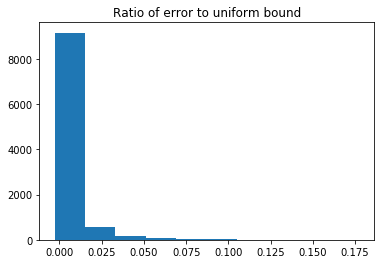

In [16]:
def check_error_bound(theta_ij, theta_cv, ij_error_terms, plot=False):
    err_bound = ij_error_terms['err_bound']
    
    omega_sufficient = np.all(np.logical_and(
              theta_ij <= ij_error_terms['theta_max'],
              theta_ij >= ij_error_terms['theta_min']))
    print('Omega sufficient:\t', omega_sufficient)
    
    err = theta_cv - theta_ij
    bound_sufficient = np.all(np.abs(err) < err_bound)
    print('Error bound sufficient:\t', bound_sufficient)
    print('Max error bound ratio:\t', np.max(np.abs(err) / err_bound))
    
    if plot:
        plt.hist(err / err_bound);
        plt.title('Ratio of error to uniform bound');
    
    return bound_sufficient and omega_sufficient

assert check_error_bound(theta_ij, theta_cv, ij_error_terms, plot=True)

# Optimially choosing the size of $\Omega_\theta$.

As is clear from the above discussion and the definition of the function ``get_ij_error_bounds``, we have a map from the bounds $(\theta_{min}, \theta_{max}) \mapsto \epsilon$, where $|\hat\theta_{IJ}(w) - \hat\theta(w)| < \epsilon$.  Tigher bounds on $\theta$ lead to a smaller $\epsilon$.   If we find that the original choice of $\Omega_\theta$ is larger than necessary, we can reduce its size, potentially decreasing the error bound.

In [17]:
# We can potentially decrease the size of \Omega_\theta.
def get_implied_omega_theta(theta_ij, ij_error_terms):
    err_bound = ij_error_terms['err_bound']
    pred_theta_max = np.max(theta_ij) + err_bound
    pred_theta_min = np.min(theta_ij) - err_bound
    return (pred_theta_min, pred_theta_max)

In [18]:
bound_change = float('inf')
tol = 1e-4
pred_theta_min = theta_min
pred_theta_max = theta_max
print('Original Omega_theta:\t{}'.format((pred_theta_min, pred_theta_max)))
while bound_change > tol:
    print('\n')
    new_pred_theta_min, new_pred_theta_max = get_implied_omega_theta(theta_ij, ij_error_terms)
    print('Implied Omega_theta:\t{}'.format((pred_theta_min, pred_theta_max)))
    bound_change = np.abs(new_pred_theta_min - pred_theta_min) + np.abs(new_pred_theta_max - pred_theta_max)
    print('Bound change: {}'.format(bound_change))
    pred_theta_min = new_pred_theta_min
    pred_theta_max = new_pred_theta_max
    new_ij_error_terms = get_ij_error_bounds(pred_theta_min, pred_theta_max, x)

    print('Results for new bounds:')
    bounds_ok = check_error_bound(theta_ij, theta_cv, new_ij_error_terms)
    if not bounds_ok:
        print('################\nBounds not ok -- terminating.')
        bound_change = 0


Original Omega_theta:	(-2.316100947805593, -2.276100947805593)


Implied Omega_theta:	(-2.316100947805593, -2.276100947805593)
Bound change: 0.03920659533492721
Results for new bounds:
Omega sufficient:	 True
Error bound sufficient:	 True
Max error bound ratio:	 0.19095411598165413


Implied Omega_theta:	(-2.296202666330213, -2.29540926166514)
Bound change: 0.0
Results for new bounds:
Omega sufficient:	 True
Error bound sufficient:	 True
Max error bound ratio:	 0.19095411598165413
